2017 Edition

# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well-known clustering algorithm to detect anomaly network connections based on statistics about each of them. A thorough overview of K-means clustering, from a research perspective, can be found in the following wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unusual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measure the similarity between any two data points, K-means requires the definition of a distance function between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centers of those runs and input the centers as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an Euclidean distance between any two points in $d$-dimensional data space

</div>

In [1]:
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum([(d1-d2)**2 for d1, d2 in zip(p1, p2)]))

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

<div class="alert alert-success">
<b><i>What is the euclidean distance?</i></b>
<br><br>
The euclidean distance is the ordinary distance between two points in a $n$-dimensional space; in other words, it's the straight-line distance between the two points that translates into the rooted sum of the squared difference of the two points for each different dimension.
<br>
In formulas:
\begin{align}
d(\mathbf{p},\mathbf{q}) = d(\mathbf{q},\mathbf{p}) &= \sqrt{(\mathit{q}_1-\mathit{p}_1)^2+(\mathit{q}_2-\mathit{p}_2)^2+\dots+(\mathit{q}_n-\mathit{p}_n)^2} \\
&=\sqrt{\sum_{i=1}^n(\mathit{q}_i-\mathit{p}_i)^2}
\end{align}
</div>

#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

In [2]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    distances = [euclidean_distance(datapoint, _) for _ in centroids]
    return np.argmin(distances)

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

In [3]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    centroids = data
    np.random.shuffle(centroids)
    return centroids[:k]

assert(len(
    randomize_centroids(np.array([np.array([2,1,2]), np.array([1,2,1]), np.array([3,1,2])]), 
        2)) == 2), "Wrong function"

#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop criteria of the algorithm.

</div>

In [4]:
MAX_ITERATIONS = 5

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if num_iterations > MAX_ITERATIONS:
        return True
    # check if the centroids don't move (or very slightly)
    dist = [euclidean_distance(curr, old) for curr, old in zip(centroids, old_centroids)]
    if all(dist[x]<threshold for x in range(len(dist))):
        return True
    return False

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

In [5]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    for i, c in enumerate(cluster):
        centroids[i] = sum(c)/len(c)
    return centroids

#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm skeleton below, with the functions you wrote above.

</div>

In [6]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for point in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(point, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(point)
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(clusters, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations):
            break
    
    return centroids

Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


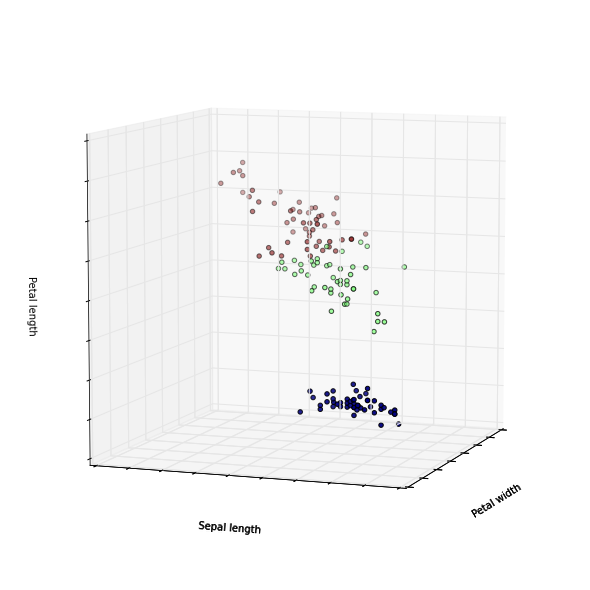

In [7]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

plt.show()

# Here we use sci-kit learn implementation of K-means
# centers =cluster.KMeans(n_clusters=3)
# centers.fit(X_iris) 
# labels = centers2.labels_


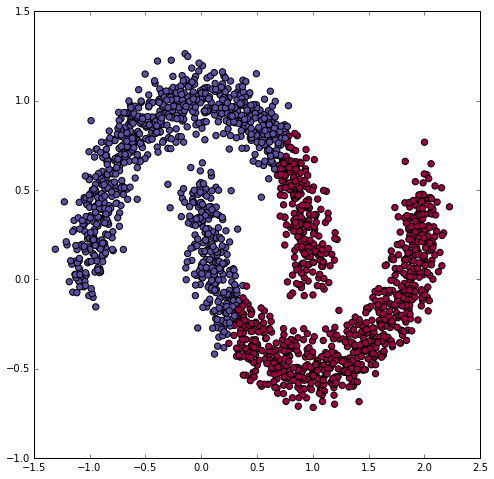

In [8]:
# moon
np.random.seed(0)
X, y = datasets.make_moons(2000, noise=0.1)

centers = kmeans(X, k=2)
labels = [find_closest_centroid(p, centers) for p in X]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

plt.show()

<div class="alert alert-success">
With this dataset, we can clearly see one of the main problems of the clustering technique. The visual division of the two clusters is totally different than the effective division computed by the algorithm.
</div>

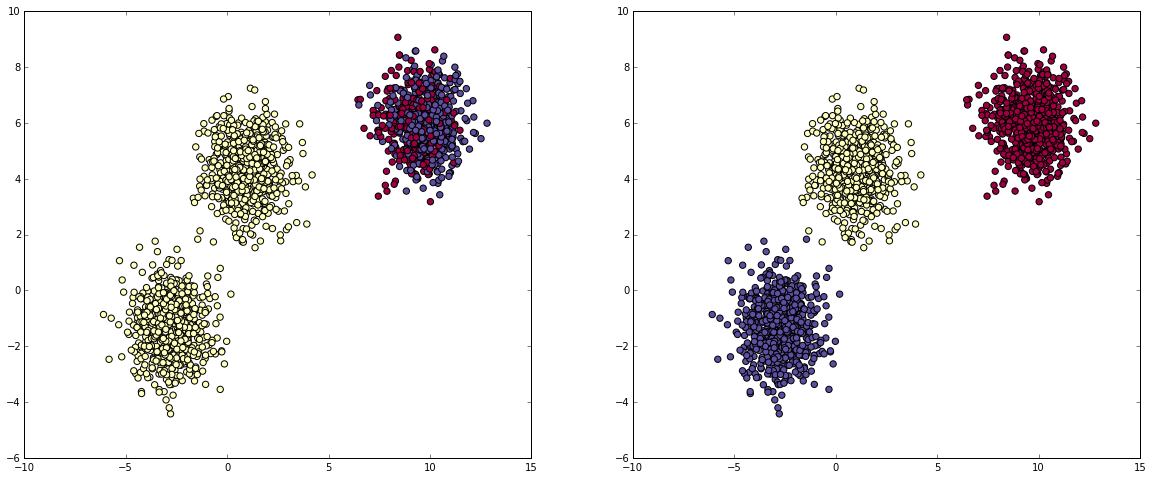

In [9]:
# blob
np.random.seed(0)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]

plt.figure(1, figsize=(20, 8))
plt.subplot("121")
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

# blob with randomized initial centers
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]

plt.subplot("122")
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

plt.show()

<div class="alert alert-success">
The blob dataset above shows another problem with clustering. The left plot represents the data clusterized in 3 clusters with the centroids initialized with a random seed set to 0. The right plot instead has no constraints on the initial centroids and so they are always chosen randomly.
<br><br>
This example shows us that the effectivness and the accuracy of the clustering technique is highly dependant on different factors and one of them is the choice of the initial centroids.
</div>

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [10]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel
from operator import add
import seaborn as sns

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase!!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [11]:
def parseLine(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector = [x for i, x in enumerate(vector) if i not in [1, 2, 3]]
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine).cache()

# we only need the data, not the label
data = labelsAndData.map(lambda x : x[1]).cache()

# number of connections
n = data.count()

In [12]:
print("Number of connections:", n)
print("Details per connection:", len(data.first()))

Number of connections: 4898431
Details per connection: 38


In [13]:
x = labelsAndData.map(lambda x: x[0]).distinct().count()
print("Total number of labels:\n", x)
y = labelsAndData.map(lambda x : (x[0], 1)).reduceByKey(add).collect()
print("The labels available and their occurrence in the dataset is:\n")
for _ in y:
    print("%20s\t%d" %(_[0], _[1]))

Total number of labels:
 23
The labels available and their occurrence in the dataset is:

       guess_passwd.	53
         loadmodule.	9
                spy.	2
                phf.	4
               back.	2203
                pod.	264
               nmap.	2316
              smurf.	2807886
              satan.	15892
        warezmaster.	20
               land.	21
            ipsweep.	12481
           teardrop.	979
            neptune.	1072017
           multihop.	7
               perl.	3
    buffer_overflow.	30
               imap.	12
        warezclient.	1020
            rootkit.	10
          ftp_write.	8
             normal.	972781
          portsweep.	10413


<div class="alert alert-danger">
TODO COMMENT
</div>

#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

In [14]:
clusters = KMeans.train(data, 2, maxIterations=10, runs=10, initializationMode="random")

<div class="alert alert-success">
Each connection has 38 attributes. If we want to cluster the data we have to decide which are the best features to use on the axis to plot the data. For this first example, let's simply use the first 3 features to do a 3D plot.
<br><br>
Let's first see how the data is divided.
</div>

In [15]:
from operator import add

__ = labelsAndData.map(lambda x : (clusters.predict(x[1]), 1)).reduceByKey(add).collect()
for _ in __:
    print("Cluster %5d\tNumber of elements: %10d" %(_[0], _[1]))

[(0, 4898426), (1, 5)]


<div class="alert alert-success">
In our tests, we got completely random results; the first time we run the training, we got the 5 million connections divided almost equally; the second time we got all connections but 5 in one cluster and 5 connections of label "portsweep" in the second cluster; while the third time we have all connections in one cluster and none in the second one.
<br><br>
This is an evidence of two things:
<br>
<ul>
<li>Clustering main problem of centroid initializations
<li>Curse of dimensionality that can be the explanation of the random results we get; the majority of the data is stuck together and goes inside the same cluster.
</ul>
<br>
<br>
We'll try now to plot the data.
</div>

<div class="alert alert-success">
First of all we get the values of the 3 axis, and then we scatter the plots. We will not plot all of the 4 million connections but only a subset of those.
<br><br>
As of now, we will just use the first 3 attributes as the first axis.
</div>

In [17]:
#data0x = data.filter(lambda x: clusters.predict(x)==0).map(lambda x: x[0]).take(50)
#data0y = data.filter(lambda x: clusters.predict(x)==0).map(lambda x: x[1]).take(50)
#data0z = data.filter(lambda x: clusters.predict(x)==0).map(lambda x: x[2]).take(50)

#data1x = data.filter(lambda x: clusters.predict(x)==1).map(lambda x: x[0]).take(50)
#data1y = data.filter(lambda x: clusters.predict(x)==1).map(lambda x: x[1]).take(50)
#data1z = data.filter(lambda x: clusters.predict(x)==1).map(lambda x: x[2]).take(50)

In [21]:
datax = data.map(lambda x: x[0]).take(1000)
datay = data.map(lambda x: x[1]).take(1000)
dataz = data.map(lambda x: x[2]).take(1000)
labels_ = data.map(lambda x: clusters.predict(x)).take(1000)

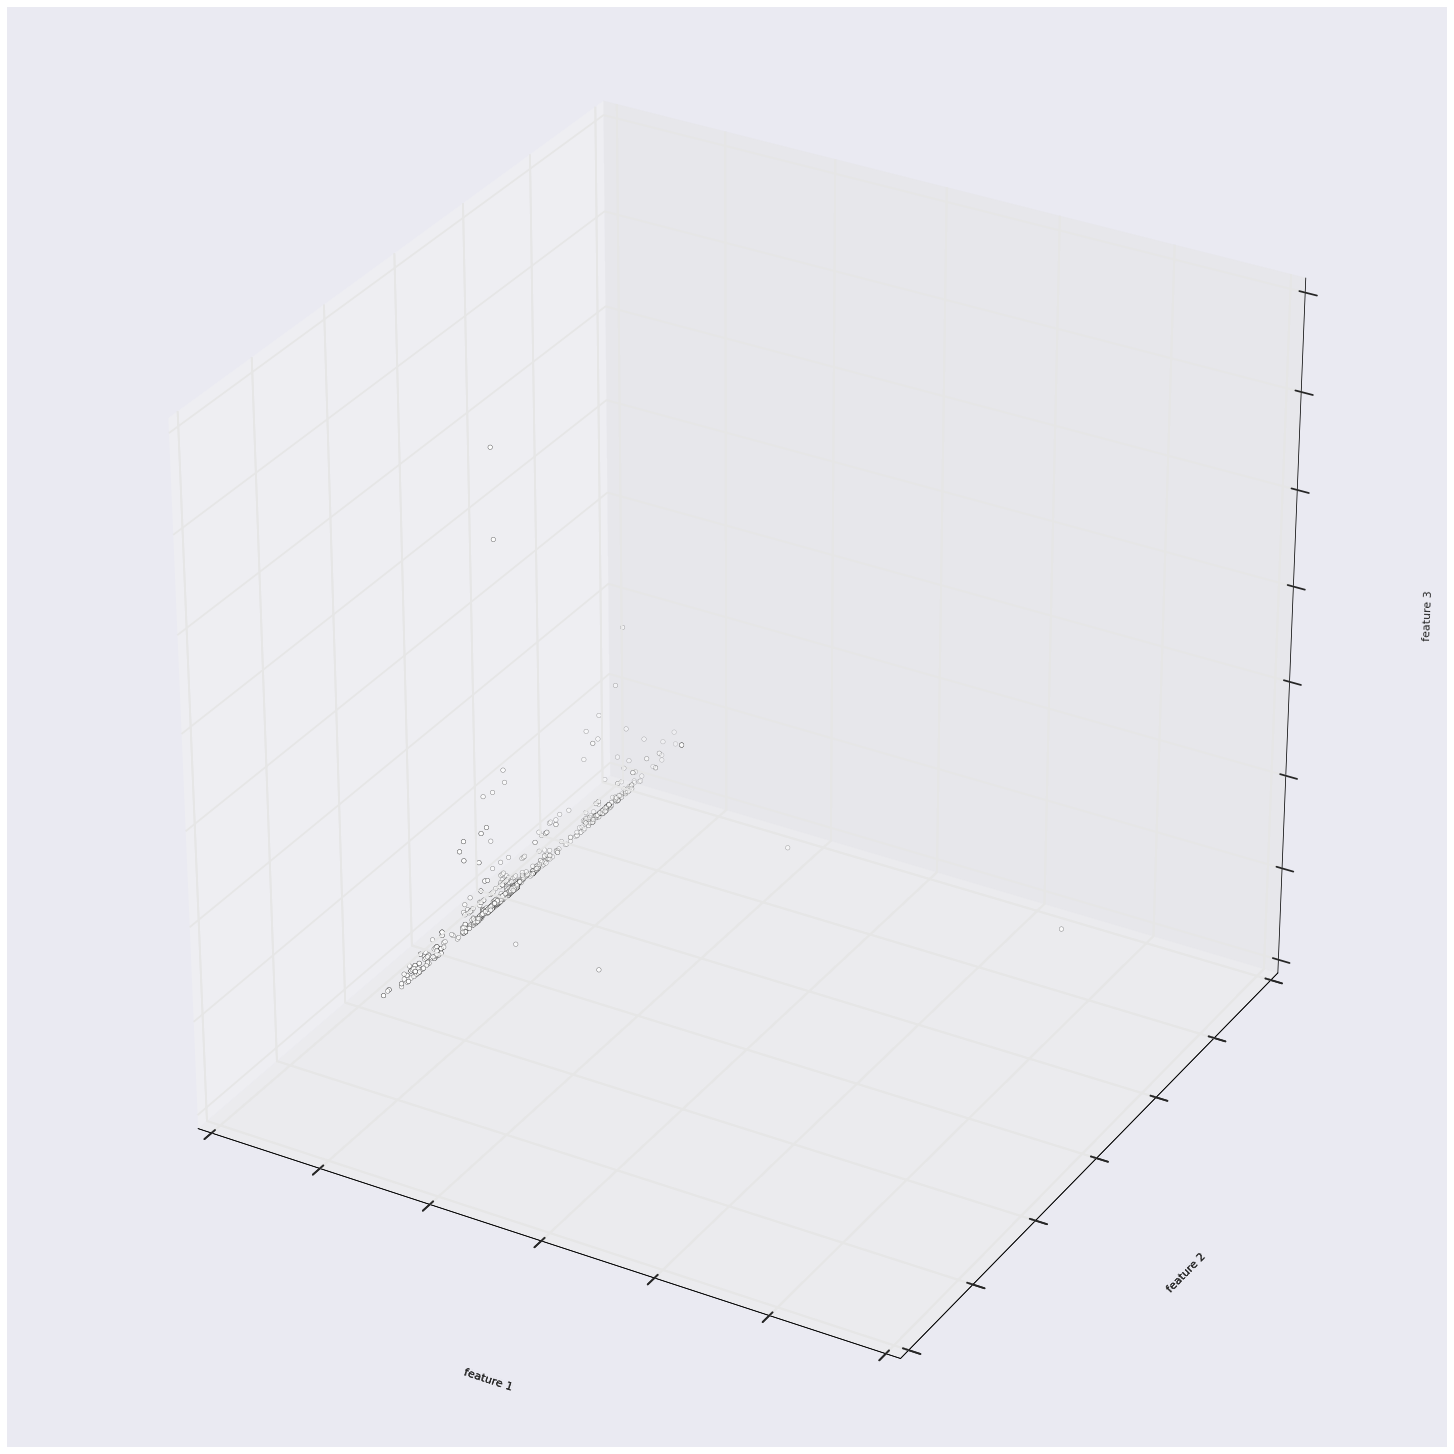

In [31]:
#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter(datax, datay, dataz, c=labels_)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

<div class="alert alert-success">
Also the plot above doesn't make a lot of sense but that is just the case because we plotted the first values on 3 random axis.
<br><br>
A relevant information that we can get from this plot, even though it plots only the first 1000 connections data, is that feature 1 and feature 3 are almost the same for every point and so maybe this features don't contain much information.
<br><br>
A good technique to get the best features and to understand how much of the information is contained in them is to use PCA.
</div>

<div class="alert alert-danger">
TODO: PCA
</div>

In [47]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import PCA as PCAmllib

vectorData = data.map(Vectors.dense)
PCAModel = PCAmllib(3).fit(vectorData)
pcaData = PCAModel.transform(vectorData).take(1000)

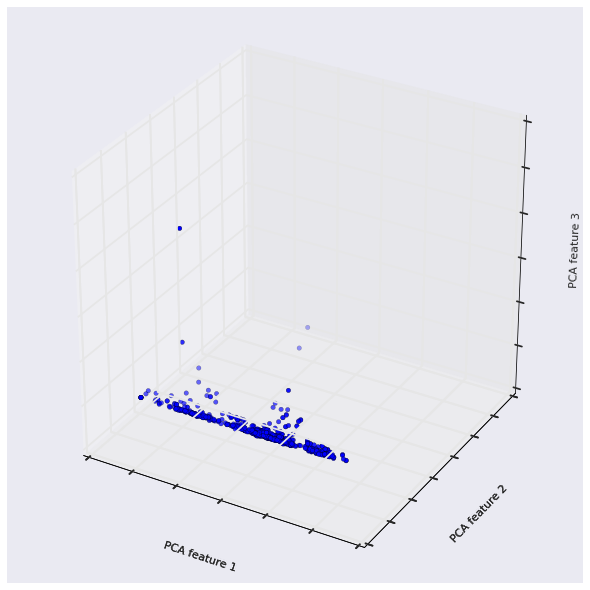

In [49]:
#pca plot
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter([x[0] for x in pcaData], [x[1] for x in pcaData], [x[2] for x in pcaData])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA feature 1')
ax.set_ylabel('PCA feature 2')
ax.set_zlabel('PCA feature 3')

plt.show()

<div class="alert alert-danger">
TODO COMMENT PCA
</div>

def estimateCovariance(df):
    """Compute the covariance matrix for a given dataframe.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        df:  A Spark dataframe with a column named 'features', which (column) consists of DenseVectors.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input dataframe.
    """
    m = df.select(df['features']).map(lambda x: x[0]).mean()
    dfZeroMean = df.select(df['features']).map(lambda x:   x[0]).map(lambda x: x-m)  # subtract the mean

    return dfZeroMean.map(lambda x: np.outer(x,x)).sum()/df.count()

from numpy.linalg import eigh

def pca(df, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        df: A Spark dataframe with a 'features' column, which (column) consists of DenseVectors.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
        scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
        rows equals the length of the arrays in the input `RDD` and the number of columns equals
        `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
        of length `k`.  Eigenvalues is an array of length d (the number of features).
     """
    cov = estimateCovariance(df)
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]  # sort eigenvals
    score = df.select(df['features']).map(lambda x: x[0]).map(lambda x: np.dot(x, components.T) )
    # Return the `k` principal components, `k` scores, and all eigenvalues

    return components.T, score, eigVals

def varianceExplained(df, k=1):
     """Calculate the fraction of variance explained by the top `k` eigenvectors.

     Args:
         df: A Spark dataframe with a 'features' column, which (column) consists of DenseVectors.
         k: The number of principal components to consider.

     Returns:
         float: A number between 0 and 1 representing the percentage of variance explained
             by the top `k` eigenvectors.
     """
     components, scores, eigenvalues = pca(df, k)  
     return sum(eigenvalues[0:k])/sum(eigenvalues)

comp, score, eigVals = pca(data)

### 2.2.3. Evaluating model

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


In [32]:
import time

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(closest_center, point)**2
t1 = time.time()
WSSSE = data.map(lambda x : error(clusters, x)).reduce(add)
print("Within Set Sum of Squared Error = " + str(WSSSE))
print("Time needed:", time.time()-t1)

Within Set Sum of Squared Error = 3.05254895755e+18
Time needed: 25.035783290863037


In [33]:
t1 = time.time()
print(clusters.computeCost(data))
print("Time needed:", time.time()-t1)

3.052548957548266e+18
Time needed: 2.5631661415100098


<div class="alert alert-success">
In the KMeans documentation, we found a method called <code>public double computeCost(RDD&lt;Vector&gt; data)</code> that actually computer the same information but in a much faster way.
<br>
We wrote the time of both methods and the improving factor is approximately 10.
</div>


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result?

</div>

In [34]:
clusterLabelCount = labelsAndData.map(lambda x : ((clusters.predict(x[1]), x[0]), 1)).reduceByKey(add).collect()

for item in clusterLabelCount:
    print("Label #%d\tClass:%20s\tOccurrences:%10d" %(item[0][0],item[0][1],item[1]))

Label #1	Class:               back.	Occurrences:      2203
Label #1	Class:               imap.	Occurrences:        12
Label #1	Class:           teardrop.	Occurrences:       979
Label #1	Class:                pod.	Occurrences:       264
Label #1	Class:              satan.	Occurrences:     15892
Label #1	Class:               land.	Occurrences:        21
Label #1	Class:          portsweep.	Occurrences:     10408
Label #1	Class:       guess_passwd.	Occurrences:        53
Label #1	Class:           multihop.	Occurrences:         7
Label #1	Class:            neptune.	Occurrences:   1072017
Label #1	Class:              smurf.	Occurrences:   2807886
Label #1	Class:             normal.	Occurrences:    972781
Label #1	Class:               nmap.	Occurrences:      2316
Label #1	Class:        warezmaster.	Occurrences:        20
Label #1	Class:                phf.	Occurrences:         4
Label #1	Class:                spy.	Occurrences:         2
Label #1	Class:         loadmodule.	Occurrences:        

<div class="alert alert-danger">
TO FIX BELOW
</div>

In [84]:
nrLabelsPerCluster = labelsAndData.map(lambda x : (clusters.predict(x[1]), x[0])).groupByKey().collect()
for _ in nrLabelsPerCluster:
    print("Cluster %5d\tNumber of classes: %10d" %(_[0], len(_[1])))

Cluster     0	Number of classes:    4898426
Cluster     1	Number of classes:          5


<div class="alert alert-success">
As we can see from this results, all of the data but 5 elements goes in one cluster while 5 elements labeled as <i>portsweep</i> go in the second cluster. (at least that was the result at the time of the comment but sometimes as we said before the result are different).
<br>
One cluster usually gets almost all the classes while the other one gets 1 or 0 classes (portsweep, more specifically).
<br><br>
The clusters are heavily unbalanced due to the disparity of the whole dataset and this tells us one important thing: that the majority of the point is stuck together and there is a really small amount of outliers (only 5 were recognized). There are surely more than 5 outliers but they hide for sure inside the first cluster.
<br><br>
The choice of k=2 could be better adapted; since there are 23 classes, it would make much more sense to use k=23 or more.
</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$? Why?

</div>

In [35]:
# k: the number of clusters
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10, runs=10, initializationMode="random")
    # calculate mean square error
    return clusters.computeCost(data)

k_vector = [2,5,10,23,30,50,70,100,120,200,300,400]

scores = [clusteringScore(data, k) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, WSSSE = %d" %(k_vector[i], score))

k =   2, WSSSE = 6379373214570355712
k =   5, WSSSE = 1165055747241957632
k =  10, WSSSE = 1095064806663185280
k =  23, WSSSE = 1094698575284540800
k =  30, WSSSE = 994403579038969728
k =  50, WSSSE = 990490536719403264
k =  70, WSSSE = 966004159630160896
k = 100, WSSSE = 966040493746292864
k = 120, WSSSE = 966139935070940032
k = 200, WSSSE = 824346863995350400
k = 300, WSSSE = 965971743139854720
k = 400, WSSSE = 965966121974612480


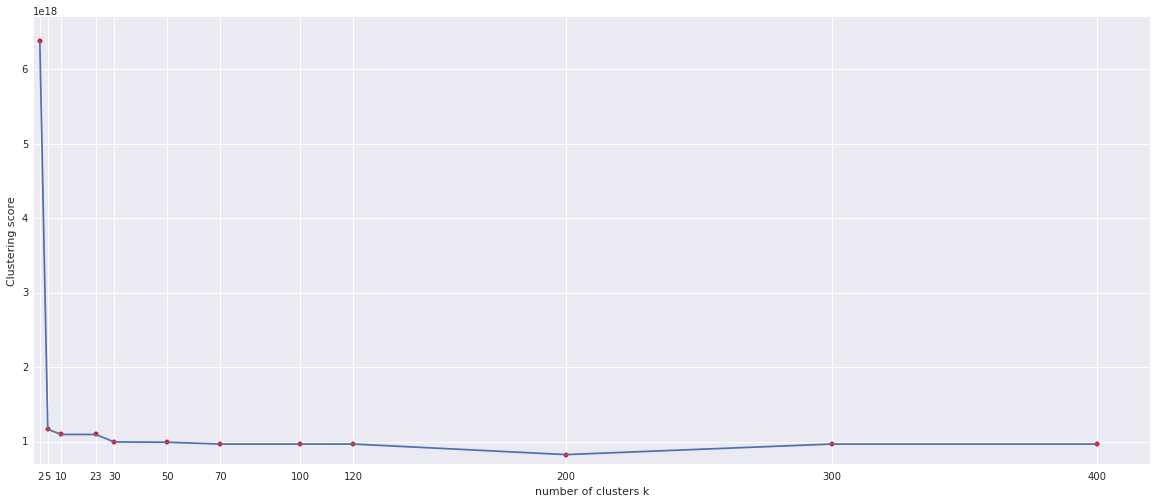

In [36]:
# plot results
plt.figure(figsize=(20,8))
plt.plot(k_vector, scores)
plt.scatter(k_vector, scores, color="r")
plt.axis([0, np.max(k_vector)*1.05, 0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.xticks(k_vector)
plt.show()

<div class="alert alert-warning">

PUT YOUR ANSWER HERE !

</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

In [85]:
def normalizeData(data):
    # number of connections
    n = data.count()

    # calculate means
    means = data.reduce(add)/n

    # calculate standard deviation of each feature
    stdevs = np.sqrt(data.map(lambda x : (x-means)**2).reduce(add)/n)
    
    stdevs[stdevs==0] = 1

    def normalize(point):
        return (point-means)/stdevs

    return data.map(normalize)

normalizedData = normalizeData(data).cache()
print(normalizedData.take(5))

[array([ -6.68331854e-02,  -1.72038228e-03,   6.81884351e-02,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e-03,  -4.54646139e-03,
        -3.28458917e-03,  -9.57233922e-03,  -8.50457842e-03,
        -2.87561127e-02,   0.00000000e+00,  -6.38979005e-04,
        -2.89113034e-02,  -1.57541507e+00,  -1.19624324e+00,
        -4.66042614e-01,  -4.65755574e-01,  -2.48285775e-01,
        -2.48130352e-01,   5.39733093e-01,  -2.56056520e-01,
        -2.01059296e-01,  -3.63913926e+00,  -1.78651044e+00,
        -1.83302273e+00,  -2.82939000e-01,  -1.25793664e+00,
        -1.56668488e-01,  -4.66404784e-01,  -4.65453641e-01,
        -2.50831829e-01,  -2.49631966e-01]), array([ -6.68331854e-02,  -1.77667956e-03,   5.32451452e-03,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e-

<div class="alert alert-danger">
TODO comment on shape and meaning
</div>

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

In [38]:
k_vector = [60,70,80,90,100,110]
scoresNormalized = [clusteringScore(normalizedData, k) for k in k_vector]
for i, score in enumerate(scoresNormalized):
    print("k = %3d, WSSSE = %d" %(k_vector[i], score))

k =  60, WSSSE = 64760924
k =  70, WSSSE = 73880704
k =  80, WSSSE = 58358336
k =  90, WSSSE = 66340229
k = 100, WSSSE = 60808748
k = 110, WSSSE = 65318165


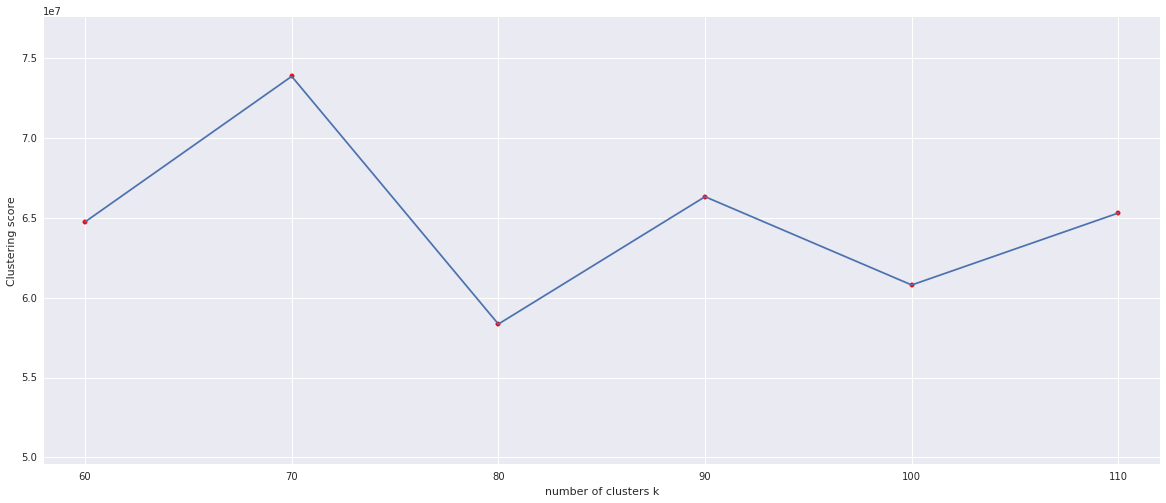

In [39]:
# plot results
plt.figure(figsize=(20,5))
plt.plot(k_vector, scoresNormalized)
plt.scatter(k_vector, scoresNormalized, color="r")
plt.axis([58,112, 0.85*np.min(scoresNormalized), 1.05*np.max(scoresNormalized)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.xticks(k_vector)
plt.show()

<div class='alert alert-warning'>

PUT YOUR ANSWER HERE !!!

</div>

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

In [87]:
#let's use k as the best in the previous question = 80
clusters = KMeans.train(normalizedData, k=80, maxIterations=10, runs=10, initializationMode="random")

#get three axis on the first three attributes
datax_norm = normalizedData.map(lambda x: x[0]).take(1000)
datay_norm = normalizedData.map(lambda x: x[1]).take(1000)
dataz_norm = normalizedData.map(lambda x: x[2]).take(1000)
labels_norm = normalizedData.map(lambda x: clusters.predict(x)).take(1000)

#let's do also pca to see the difference
vectorData = normalizedData.map(Vectors.dense)
PCAModel = PCAmllib(3).fit(vectorData)
pcaData = PCAModel.transform(vectorData).take(1000)

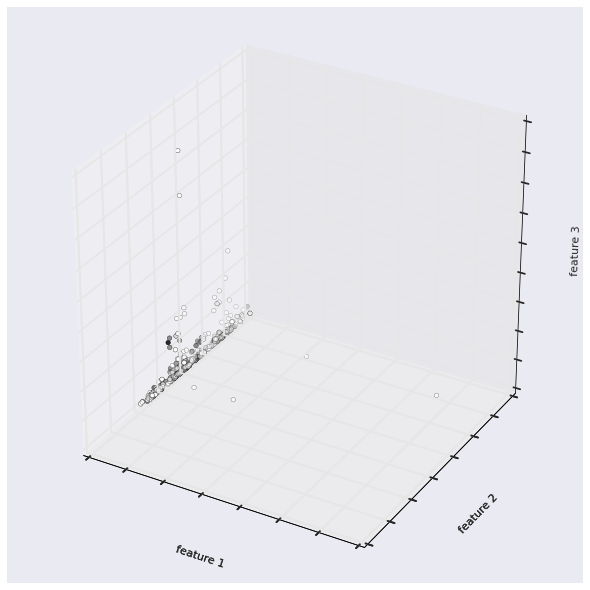

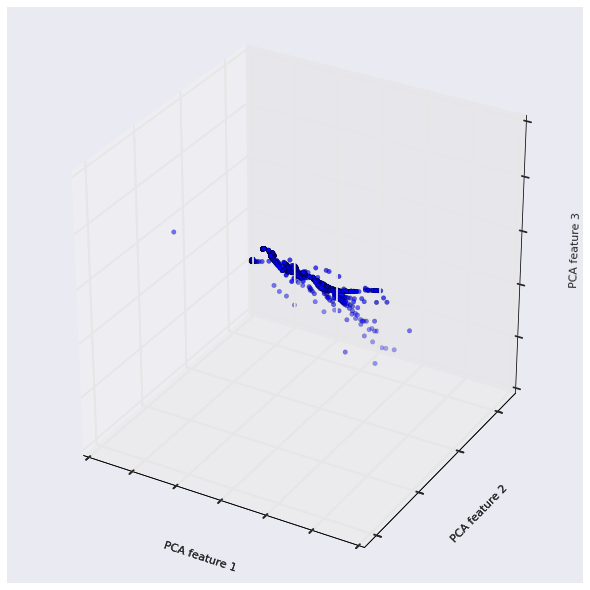

In [89]:
#plots


fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter(datax_norm, datay_norm, dataz_norm, c=labels_norm)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

#pca plot
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter([x[0] for x in pcaData], [x[1] for x in pcaData], [x[2] for x in pcaData])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA feature 1')
ax.set_ylabel('PCA feature 2')
ax.set_zlabel('PCA feature 3')

plt.show()

<div class="alert alert-warning">


PUT YOUR ANSWER HERE !!!

</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, subtraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical feature into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

In [90]:
feat1 = raw_data.map(lambda x : x.split(",")[1]).distinct().collect()
feat2 = raw_data.map(lambda x : x.split(",")[2]).distinct().collect()
feat3 = raw_data.map(lambda x : x.split(",")[3]).distinct().collect()

In [94]:
print("feature 1:\n", feat1)
print("\nfeature 2:\n", feat2)
print("\nfeature 3:\n", feat3)

feature 1:
 ['udp', 'tcp', 'icmp']

feature 2:
 ['whois', 'pop_3', 'harvest', 'uucp_path', 'other', 'systat', 'ecr_i', 'vmnet', 'kshell', 'time', 'Z39_50', 'name', 'http', 'tftp_u', 'netbios_dgm', 'remote_job', 'ftp', 'domain_u', 'discard', 'ldap', 'eco_i', 'finger', 'http_2784', 'private', 'printer', 'sql_net', 'sunrpc', 'nnsp', 'iso_tsap', 'pop_2', 'exec', 'urp_i', 'daytime', 'netbios_ns', 'IRC', 'ftp_data', 'urh_i', 'http_443', 'bgp', 'domain', 'ctf', 'hostnames', 'mtp', 'netstat', 'login', 'klogin', 'nntp', 'ssh', 'imap4', 'aol', 'efs', 'X11', 'csnet_ns', 'rje', 'smtp', 'telnet', 'tim_i', 'shell', 'http_8001', 'supdup', 'red_i', 'pm_dump', 'courier', 'echo', 'ntp_u', 'netbios_ssn', 'uucp', 'gopher', 'auth', 'link']

feature 3:
 ['SH', 'OTH', 'S1', 'REJ', 'S2', 'RSTOS0', 'RSTO', 'S0', 'RSTR', 'S3', 'SF']


<div class="alert alert-danger">
TODO: let's print and tell what this data is.
</div>

In [95]:
def parseLineWithHotEncoding(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorical feature
    featureOfCol1 = [0]*len(feat1)
    featureOfCol1[featureOfCol1.index(vector[1])] = 1
    # the binary features that are encoded from the second categorical feature
    featureOfCol2 = [0]*len(feat2)
    featureOfCol2[featureOfCol2.index(vector[2])] = 1
    # the binary features that are encoded from the third categorical feature
    featureOfCol3 = [0]*len(feat3)
    featureOfCol3[featureOfCol3.index(vector[3])] = 1
    
    # construct the new vector
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.values().cache()

normalizedData = normalizeData(data).cache()

### 2.3.2. Building models

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

In [42]:
k_vector = [80,90,100,110,120,130,140,150,160]
scores = [clusteringScore(normalizedData, k) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, WSSSE = %d" %(k_vector[i], score))

k =  80, WSSSE = 71208780
k =  90, WSSSE = 64787732
k = 100, WSSSE = 61353049
k = 110, WSSSE = 53303332
k = 120, WSSSE = 54919222
k = 130, WSSSE = 58705932
k = 140, WSSSE = 59443815
k = 150, WSSSE = 48552830
k = 160, WSSSE = 59872060


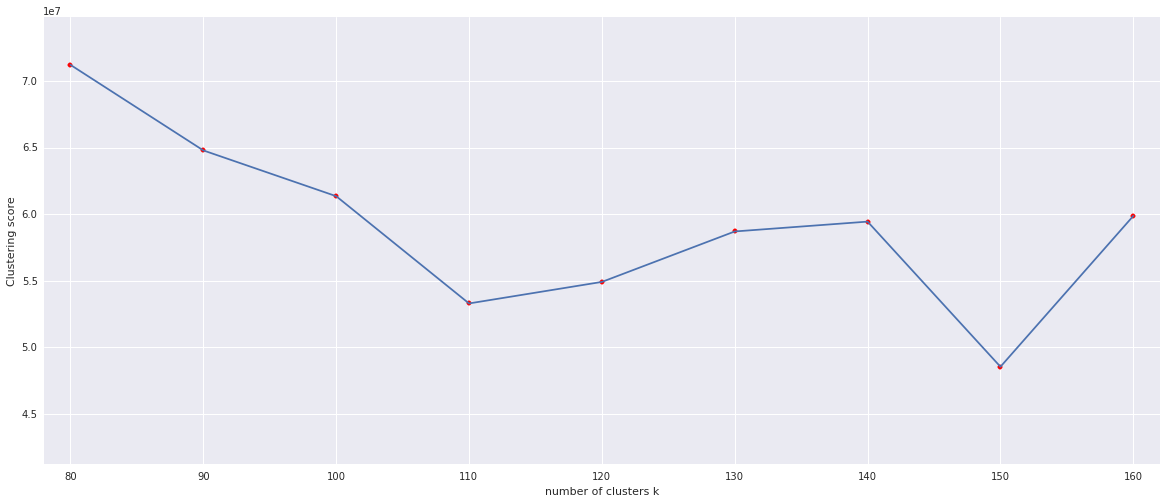

In [43]:
# plot results
plt.figure(figsize=(20,8))
plt.plot(k_vector, scores)
plt.scatter(k_vector, scores, color="r")
plt.axis([78,162,0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.xticks(k_vector)
plt.show()

<div class="alert alert-warning">


PUT YOUR ANSWER HERE !!!


</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide when there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [96]:
bestK = 100

In [97]:
clusters = KMeans.train(data, bestK, maxIterations=10, runs=10, initializationMode="random")

In [98]:
ordered = normalizedData.map(lambda x : (error(clusters, x), x)).takeOrdered(5000, lambda key : key[0])

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 175.0 failed 4 times, most recent failure: Lost task 6.3 in stage 175.0 (TID 1572, spark-worker1-97363-prod, executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/spark/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/spark/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/opt/spark/python/pyspark/rdd.py", line 1290, in <lambda>
    return self.mapPartitions(lambda it: [heapq.nsmallest(num, it, key)]).reduce(merge)
  File "/opt/conda/lib/python3.5/heapq.py", line 508, in nsmallest
    result = [(key(elem), i, elem) for i, elem in zip(range(n), it)]
  File "/opt/conda/lib/python3.5/heapq.py", line 508, in <listcomp>
    result = [(key(elem), i, elem) for i, elem in zip(range(n), it)]
  File "<ipython-input-98-9a9ab9337e8d>", line 1, in <lambda>
NameError: name 'error' is not defined

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1958)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:934)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor48.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/spark/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/spark/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/opt/spark/python/pyspark/rdd.py", line 1290, in <lambda>
    return self.mapPartitions(lambda it: [heapq.nsmallest(num, it, key)]).reduce(merge)
  File "/opt/conda/lib/python3.5/heapq.py", line 508, in nsmallest
    result = [(key(elem), i, elem) for i, elem in zip(range(n), it)]
  File "/opt/conda/lib/python3.5/heapq.py", line 508, in <listcomp>
    result = [(key(elem), i, elem) for i, elem in zip(range(n), it)]
  File "<ipython-input-98-9a9ab9337e8d>", line 1, in <lambda>
NameError: name 'error' is not defined

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
plt.figure(figsize=(20,10))
plt.plot([x[0] for x in ordered])
plt.show()

100


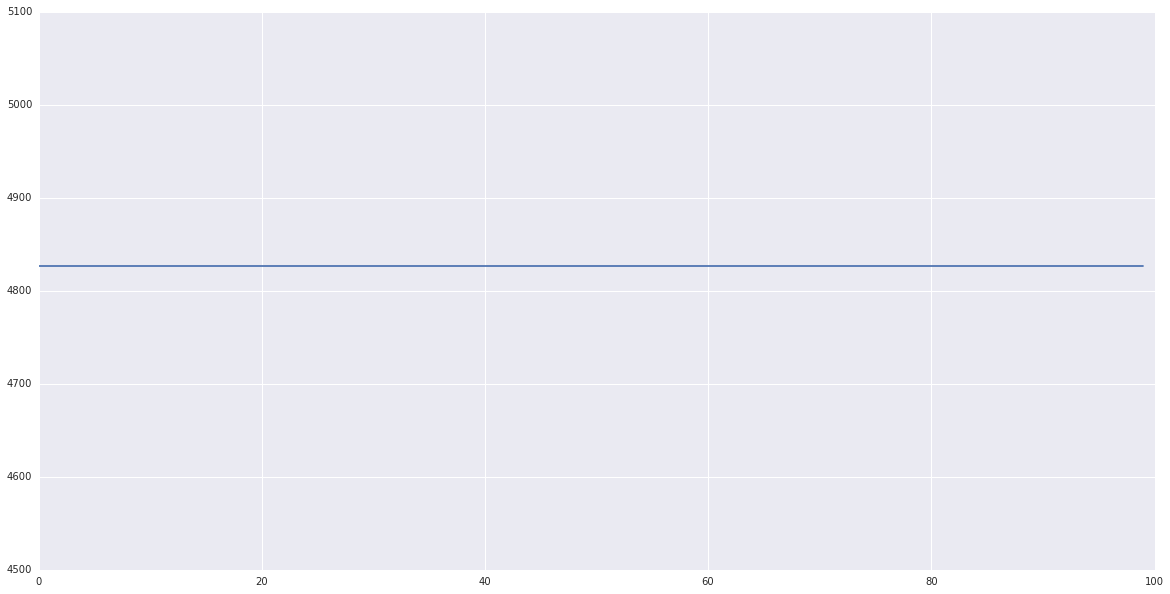

In [48]:
xx = [x[0] for x in ordered[0:100]]
print(len(xx))
plt.figure(figsize=(20,10))
plt.plot(xx)
plt.show()

<div class="alert alert-danger">
TODO: plot the line of distance from center for the points ordered by increasing distance
<br>
TODO: understand which is the best threshold and plot number of anomalies for given threshold
</div>

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

</div>

Here are some additional information about the metrics we suggest to use:
- <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">Silhouette</a>
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.  

<ul></ul>

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a `map/reduce` algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.

</div>